# Select fCpGs

Run all cells to:
- Import TCGA and normal samples methylation data
- Select Clock (fCpG) sites and save
- Refine final list of tumors and save
- Calculate $c_\beta$ values and save
- Save beta values of Clock sites separately
- Generate figures relating to this site selection
- Calculate some statistics

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts
import util as local_util

In [ ]:
## Output directories

figure_outdir = 'figures'
output_dir = 'outputs'

os.makedirs(figure_outdir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [5]:
## Import data

# Returns list of "neutral" CpGs based on 450k and 850k array annotations
neutral_DNA_CpG_list = local_util.getNeutralDNACpGs()

# Import TCGA and normals data
data = local_util.getDataDict()

## Select 500 CpGs

In [19]:
# Return the Clock set of CpGs
Clock_CpGs_final_set = local_util.gen_CpG_set(data, neutral_DNA_CpG_list)

# Outfile path
Clock_CpGs_filepath = os.path.join(output_dir, 'Clock_CpGs.txt')

# Save Clock sites, don't overwrite existing file
if os.path.exists(Clock_CpGs_filepath):
    existing_set = np.loadtxt(Clock_CpGs_filepath, dtype=str)
    assert (np.sort(Clock_CpGs_final_set) == np.sort(existing_set)).all()
    print('Current output matches existing file.')
else:
    np.savetxt(Clock_CpGs_filepath, Clock_CpGs_final_set, fmt='%s')

Selecting CpGs with 634 TCGA tumors and 79 normal samples


KeyboardInterrupt: 

## Remove tumors for too many missing Clock beta values

In [7]:
final_sample_set = data['tumor']['beta_values'].columns[data['tumor']['beta_values'].loc[Clock_CpGs_final_set].isna().mean(axis=0) < 0.05]

# Count difference in # tumors
n_before = data['tumor']['beta_values'].shape[1]
n_after = final_sample_set.shape[0]

print(f'{n_before - n_after} tumors were filtered for having >=5% missing values for the 500 selected sites.')
print(f'{n_after} tumors left')

10 tumors were filtered for having >=5% missing values for the 500 selected sites.
624 tumors left


## Calculate $c_\beta$ values

In [8]:
c_beta_final_samples = 1 - data['tumor']['beta_values'].loc[Clock_CpGs_final_set, final_sample_set].std(axis=0)

# Outfile path
c_beta_filepath = os.path.join(output_dir, 'TCGA.c_beta.txt')

# Save c_beta values, don't overwrite existing file
if os.path.exists(c_beta_filepath):
    existing_c_beta = pd.read_table(c_beta_filepath, index_col=0, header=None).squeeze("columns")
    assert (c_beta_final_samples - existing_c_beta < 1e-6).all()
    print('Current output matches existing file.')
else:
    c_beta_final_samples.to_csv(c_beta_filepath, sep='\t', header=False)

## Save beta values of Clock sites separately
Much smaller file, easier to import in other scripts/notebooks

In [9]:
data['tumor']['beta_values'].loc[Clock_CpGs_final_set].to_csv(
    os.path.join(consts['TCGA_datadir'], 'TCGA.methyl.balancedSites.tsv'),
    sep='\t'
)

## Figures

In [ ]:
## Configure graph
sf = consts['sf']
figsize = np.array([9, 7])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

### Prepare data object for figures

In [10]:
## Add beta_means, beta_stds, beta_nans to data dict
local_util.addMeanStdsNans(data)

### Visualization of Site Selection - Figures 1A and 1B

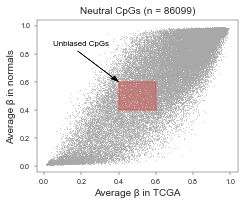

In [13]:
## Figure 1A

# Plot tumor and normals mean beta of each site
# Highlight region of neutral sites

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * sf)
sns.scatterplot(ax=ax, x=data['tumor']['beta_means'].loc[neutral_DNA_CpG_list],
                y=data['normal']['beta_means'].loc[neutral_DNA_CpG_list], s = 5 * sf**2,
                color=consts['palette_jco'][2], alpha=consts['opacity']
               )

# Customize figure
ax.set_xlabel('Average β in TCGA', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel('Average β in normals', fontsize=consts['labelfontsize'] * sf)
ax.set_title(f'Neutral CpGs (n = {len(neutral_DNA_CpG_list)})', fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Add highlighted region for unbiased sites
lower = 0.4
upper = 0.6
ax.fill([lower, upper, upper, lower], [lower, lower, upper, upper],
        color=consts['palette_jco'][3], alpha=0.5, lw=4 * sf)

# Add text and arrow labeling the highlighted region
ax.text(0.35, 0.85, 'Unbiased CpGs',
        ha="right", va="bottom", fontfamily='sans-serif', color='black',
        fontsize=consts['labelfontsize'] * 0.8 * sf)
ax.arrow(0.18, 0.82, 0.22, -0.22, color='black', length_includes_head=True, head_width=0.03, lw=0.5)

# Save figure
fig.savefig(os.path.join(figure_outdir, 'Figure_2_A.pdf'), format='pdf', pad_inches=0.1)

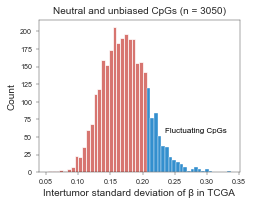

In [14]:
## Figure 1B

# Plot inter-tumor standard deviation of beta for each unbiased site
# Color blue the Clock sites selected (most variable sites)

# Generate the set of unbiased sites
balanced_means_CpGs = local_util.getCpG_list(data, local_util.CLOCK_CRITERIA, starting_CpG_list=neutral_DNA_CpG_list)

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * sf)
sns.histplot(ax=ax,      # Non-fluctuating sites
             x=data['tumor']['beta_stds'].loc[balanced_means_CpGs[~np.isin(balanced_means_CpGs, Clock_CpGs_final_set)]],
             color=consts['palette_jco'][3], alpha=consts['opacity']
            )
sns.histplot(ax=ax,      # Fluctuating sites
             x=data['tumor']['beta_stds'].loc[Clock_CpGs_final_set],
             color=consts['palette_jco'][0], alpha=consts['opacity']
            )

# Customize figure
ax.set_xlabel('Intertumor standard deviation of β in TCGA', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=consts['labelfontsize'] * sf)
ax.set_title(f'Neutral and unbiased CpGs (n = {len(balanced_means_CpGs)})', fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Label fluctuating sites
ax.text(0.235, 55, 'Fluctuating CpGs',
        ha="left", va="bottom", fontfamily='sans-serif', color='black',
        fontsize=consts['labelfontsize'] * 0.8 * sf)

# Save figure
fig.savefig(os.path.join(figure_outdir, 'Figure_2_B.pdf'), format='pdf', pad_inches=0.1)

### Display CpG Examples - Figure 2E

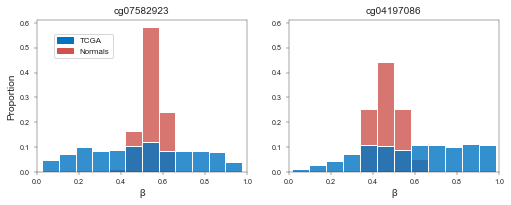

In [15]:
## Plot beta value distribution of two example CpG sites in tumors and normals

CpGs_chosen = ['cg07582923', 'cg04197086']

# Create plot axes
fig, axes = plt.subplots(1, 2, figsize=figsize * sf * [2.3, 1])

# Select colors and create legend
color_dict = {'TCGA':consts['palette_jco'][0], 'Normals':consts['palette_jco'][3]}
patches = [mpatches.Patch(color=color_dict[cohort], label=cohort) for cohort in color_dict.keys()]
plots_x, plots_y = axes[0].get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper left',
           bbox_to_anchor=(plots_x - .33, plots_y - 0.05),
           fontsize=0.8*consts['labelfontsize'] * sf
          )



# Max y-axis top limit (between the two plots)
# Used to align the y-axes after plotting
ymax_max = 0

for i, CpG in enumerate(CpGs_chosen):
    ax = axes[i]
    
    # Create long-form dataframe with "Cohort" variable
    plot_data = pd.concat([
        pd.DataFrame({'beta':data['tumor']['beta_values_SELECTION'].loc[CpG], 'Cohort':'TCGA'}),
        pd.DataFrame({'beta':data['normal']['beta_values_SELECTION'].loc[CpG], 'Cohort':'Normals'})
    ], axis=0)
    
    # Plot data
    sns.histplot(ax=ax, data=plot_data, x='beta', hue='Cohort',
                 common_norm=False, stat='proportion', palette=color_dict, legend=False, alpha=consts['opacity'])
    
    # Customize figure
    ax.set_xlabel('β', fontsize=consts['labelfontsize'] * sf)
    ax.set_title(CpG, fontsize=consts['labelfontsize'] * sf)
    ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    # Update max y-axis top limit
    ymax_max = max(ymax_max, ax.get_ylim()[1])

# Align both plots to the same limits
axes[0].set_ylim(0, ymax_max)
axes[1].set_ylim(0, ymax_max)
axes[0].set_xlim(0, 1)
axes[1].set_xlim(0, 1)

# Only need y-axis label on left plot
axes[0].set_ylabel(axes[1].get_ylabel(), fontsize=consts['labelfontsize'] * sf)
axes[1].set_ylabel('')

# Save figure
fig.savefig(os.path.join(figure_outdir, 'Figure_2_E.pdf'), format='pdf', pad_inches=0.1)

### Statistics

In [3]:
### DELETE
# c_beta_final_samples = pd.read_table(os.path.join(output_dir, 'TCGA.c_beta.txt'), index_col=0, header=None).squeeze("columns")

In [17]:
# Calculate s_beta for tumors
s_beta_tumors = 1 - c_beta_final_samples

# Calculate s_beta for normals
# Apply same threshold for missing Clock sites
final_sample_set_normals = data['normal']['beta_values_SELECTION'].columns[data['normal']['beta_values_SELECTION'].loc[Clock_CpGs_final_set].isna().mean(axis=0) < 0.05]
s_beta_normals = data['normal']['beta_values_SELECTION'].loc[Clock_CpGs_final_set, final_sample_set_normals].std(axis=0)

# Calculate wilcoxon rank-sums p-values
pvalue = epi_util.wilcoxonRankSums(s_beta_tumors, s_beta_normals).pvalue

print(f'Median standard deviation of clock beta values in TCGA tumors: {np.median(s_beta_tumors):.3f}')
print(f'Median standard deviation of clock beta values in normal breast samples: {np.median(s_beta_normals):.3f}')
print(f'Wilcoxon rank sum test: p = {pvalue:.0e}')

Median standard deviation of clock beta values in TCGA tumors: 0.209
Median standard deviation of clock beta values in normal breast samples: 0.089
Wilcoxon rank sum test: p = 2e-45
